# Введение:
### Я получил набор данных и задачу, построить модель машинного обучения которая для снижения затрат на энергопотребление будет предсказывать температуру стали на последнем цикле.
## План работы:
   ### 1. Загрузить и проанализировать данные, понять какие мне пригодтся, а какие нет.
   ### 2. Из подходящих данных выделить признаки для обучения моделей.
   ### 3. Построить несколько моделей обучения с разными гиперпараметрами для выявления лучшей модели. Метрика заказчика - МАЕ
   ### 4. Лучшие результаты проверить на тестевой выборке



In [533]:
#pip install catboost


In [534]:
#pip install ipywidgets

In [535]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgbm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor
from catboost.utils import eval_metric
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data_arc

In [536]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [537]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [538]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [539]:
data_arc.columns = ['key', 'begin_heat_arc', 'finish_heat_arc', 'active_power', 'reactive_power']

In [540]:
data_arc['finish_heat_arc'] = pd.to_datetime(data_arc['finish_heat_arc'])

In [541]:
data_arc['begin_heat_arc'] = pd.to_datetime(data_arc['begin_heat_arc'])

In [542]:
data_arc['seconds_of_heating'] = data_arc['finish_heat_arc'] - data_arc['begin_heat_arc']

In [543]:
data_arc['seconds_of_heating'] = data_arc['seconds_of_heating'].dt.total_seconds()

In [544]:
data_arc['seconds_of_heating'] = data_arc['seconds_of_heating'].astype(int)

In [545]:
data_arc.head(10)

,key,begin_heat_arc,finish_heat_arc,active_power,reactive_power,seconds_of_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,137
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,280


In [546]:
data_arc['key1'] = data_arc['key']
data_arc.head()

,key,begin_heat_arc,finish_heat_arc,active_power,reactive_power,seconds_of_heating,key1
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1


In [547]:
data_arc_key = pd.pivot_table(data_arc, values=['key1', 'seconds_of_heating', 'active_power', 'reactive_power'], index = 'key', aggfunc=
                              {'key1': np.count_nonzero, 'seconds_of_heating': np.sum,
                              'active_power': np.sum, 'reactive_power': np.sum})

In [548]:
data_arc_key.head(10)

,active_power,key1,reactive_power,seconds_of_heating
key,,,,
1,4.878147,5,3.183241,1098
2,3.052598,4,1.998112,811
3,2.525882,5,1.599076,655
4,3.209250,4,2.060298,741
5,3.347173,4,2.252643,869
6,3.955108,4,2.689175,952
7,2.547375,4,1.561295,673
8,3.762755,4,2.680698,913
9,2.081951,5,1.478671,625


In [549]:
data_arc_key = pd.DataFrame(data_arc_key)

In [550]:
data_arc_key.reset_index(inplace  = True)


In [551]:
data_arc_key.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
key                   3214 non-null int64
active_power          3214 non-null float64
key1                  3214 non-null int64
reactive_power        3214 non-null float64
seconds_of_heating    3214 non-null int64
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [552]:
data_arc_key.columns = ['key', 'active_power', 'number_of_heats', 'reactive_power', 'seconds_of_heating']


In [553]:
data_arc_key = data_arc_key[['key', 'number_of_heats', 'seconds_of_heating', 'active_power', 'reactive_power']]

In [554]:
data_arc_key.head(10)

,key,number_of_heats,seconds_of_heating,active_power,reactive_power
0,1,5,1098,4.878147,3.183241
1,2,4,811,3.052598,1.998112
2,3,5,655,2.525882,1.599076
3,4,4,741,3.209250,2.060298
4,5,4,869,3.347173,2.252643
5,6,4,952,3.955108,2.689175
6,7,4,673,2.547375,1.561295
7,8,4,913,3.762755,2.680698
8,9,5,625,2.081951,1.478671
9,10,6,825,2.923622,2.496116


In [555]:
data_arc_key['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

#### Я создал сводную таблицу в которой показано для каждой партии: количество циклов нагревания, общее время в секундах, общая активная и реактивная мощьность

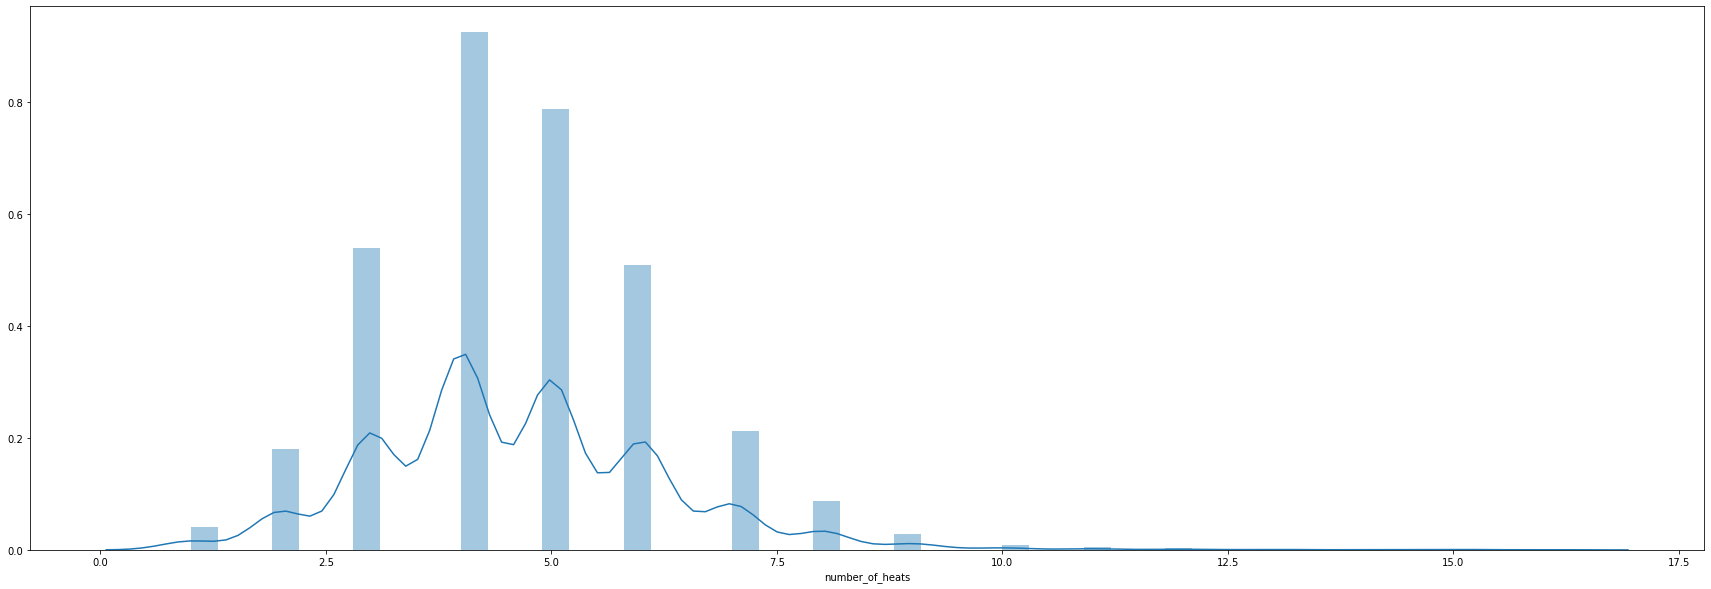

In [556]:
sns.distplot(data_arc_key['number_of_heats'])

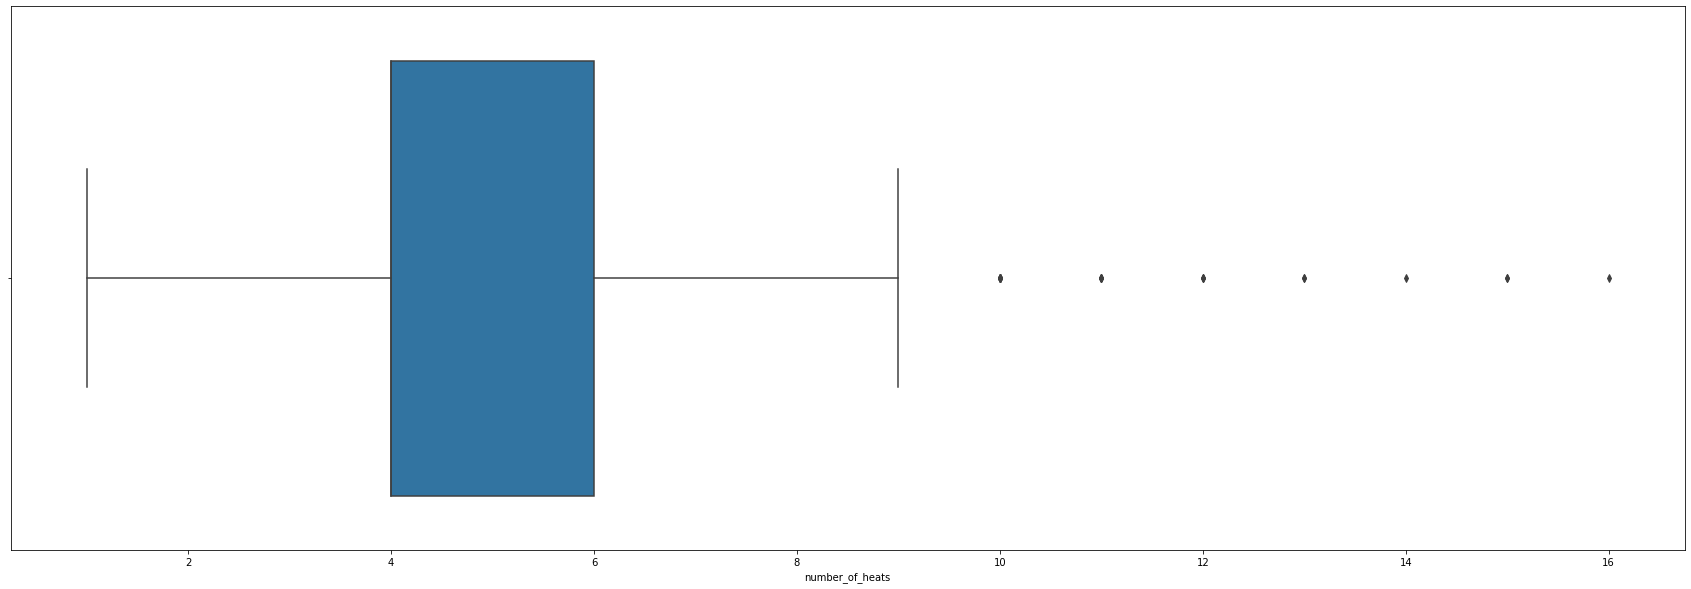

In [557]:
sns.boxplot(data_arc_key['number_of_heats'])

In [558]:
#data_arc_key = data_arc_key.query('number_of_heats < 10')

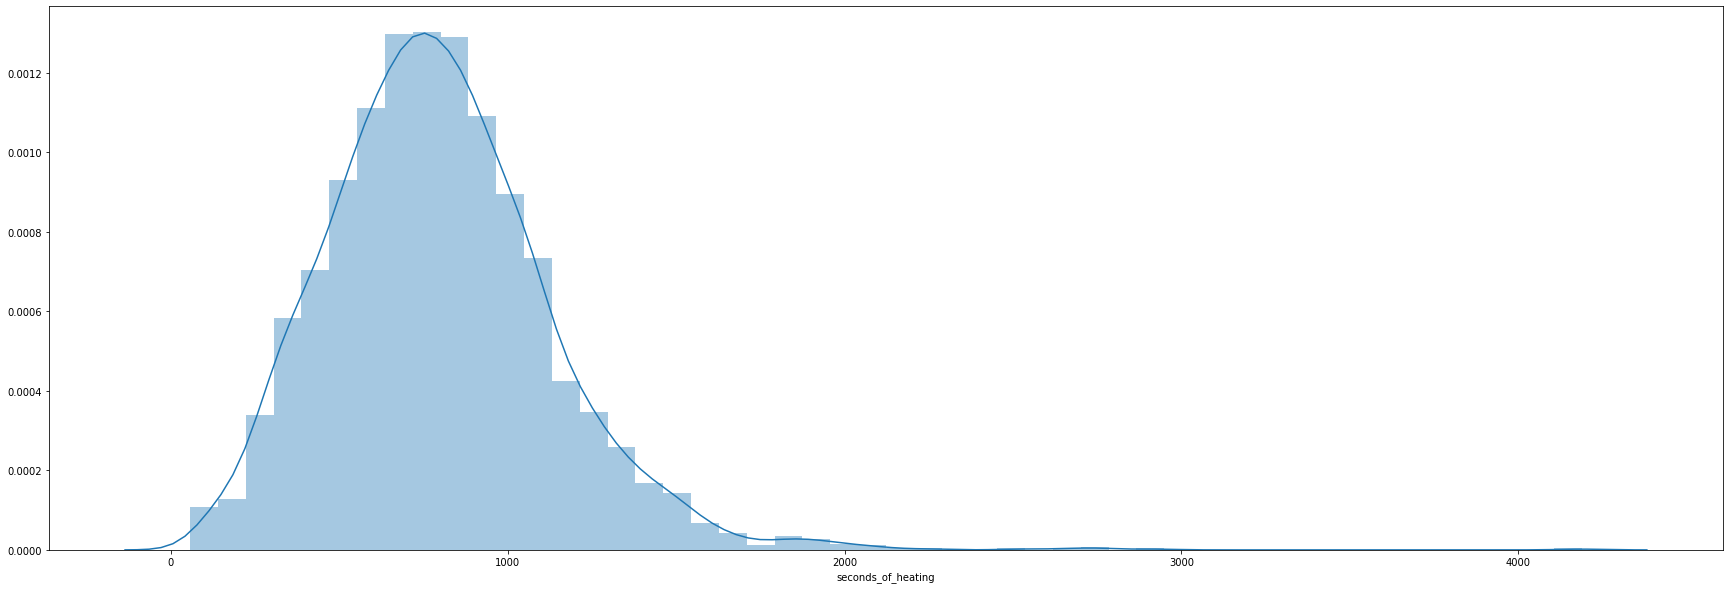

In [559]:
sns.distplot(data_arc_key['seconds_of_heating'])

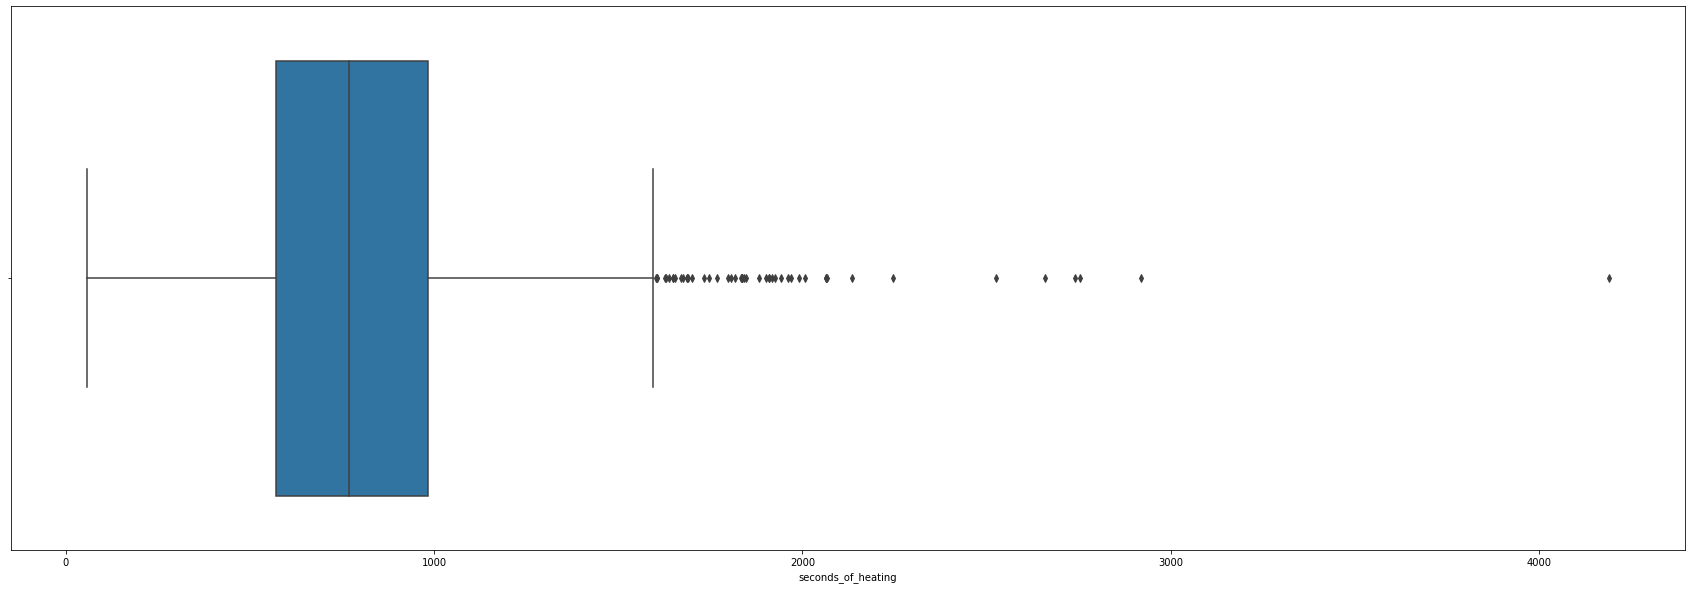

In [560]:
sns.boxplot(data_arc_key['seconds_of_heating'])

In [561]:
#data_arc_key = data_arc_key.query('seconds_of_heating < 1600')

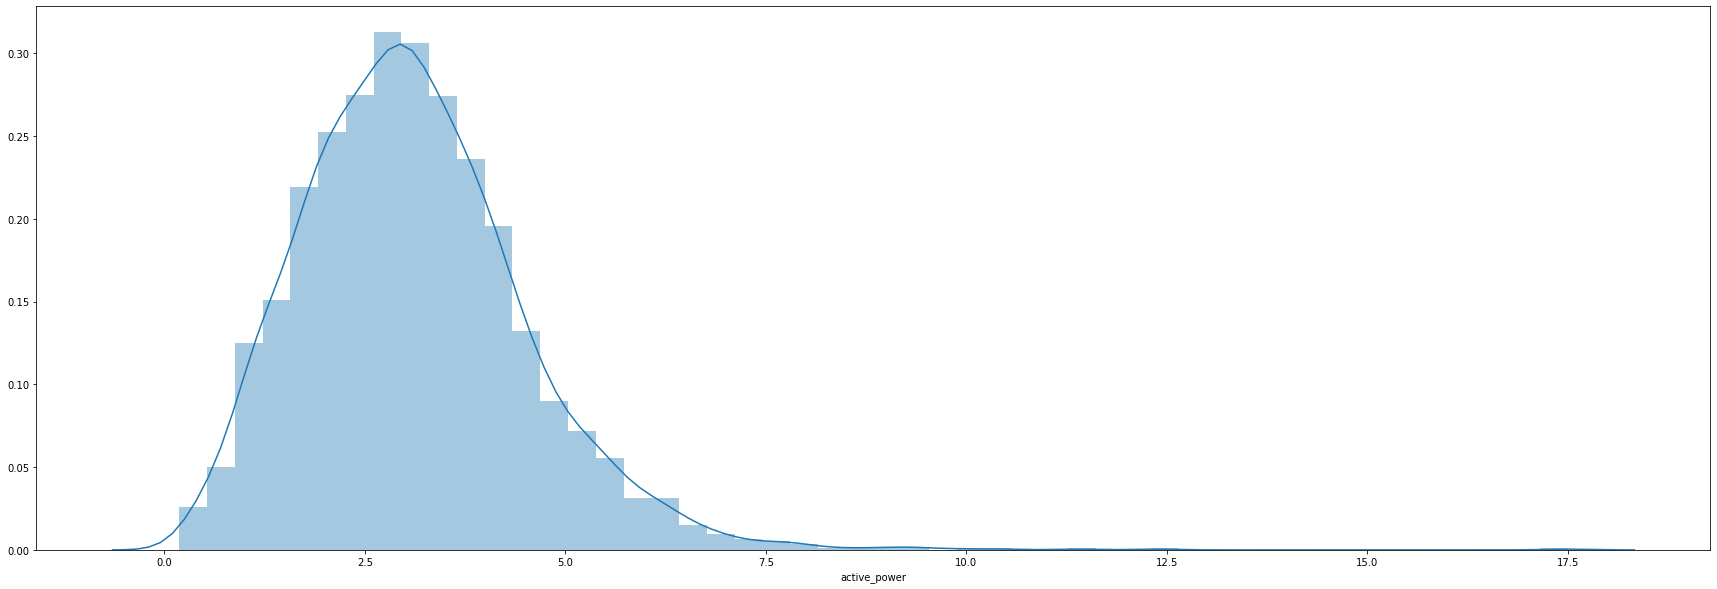

In [562]:
sns.distplot(data_arc_key['active_power'])

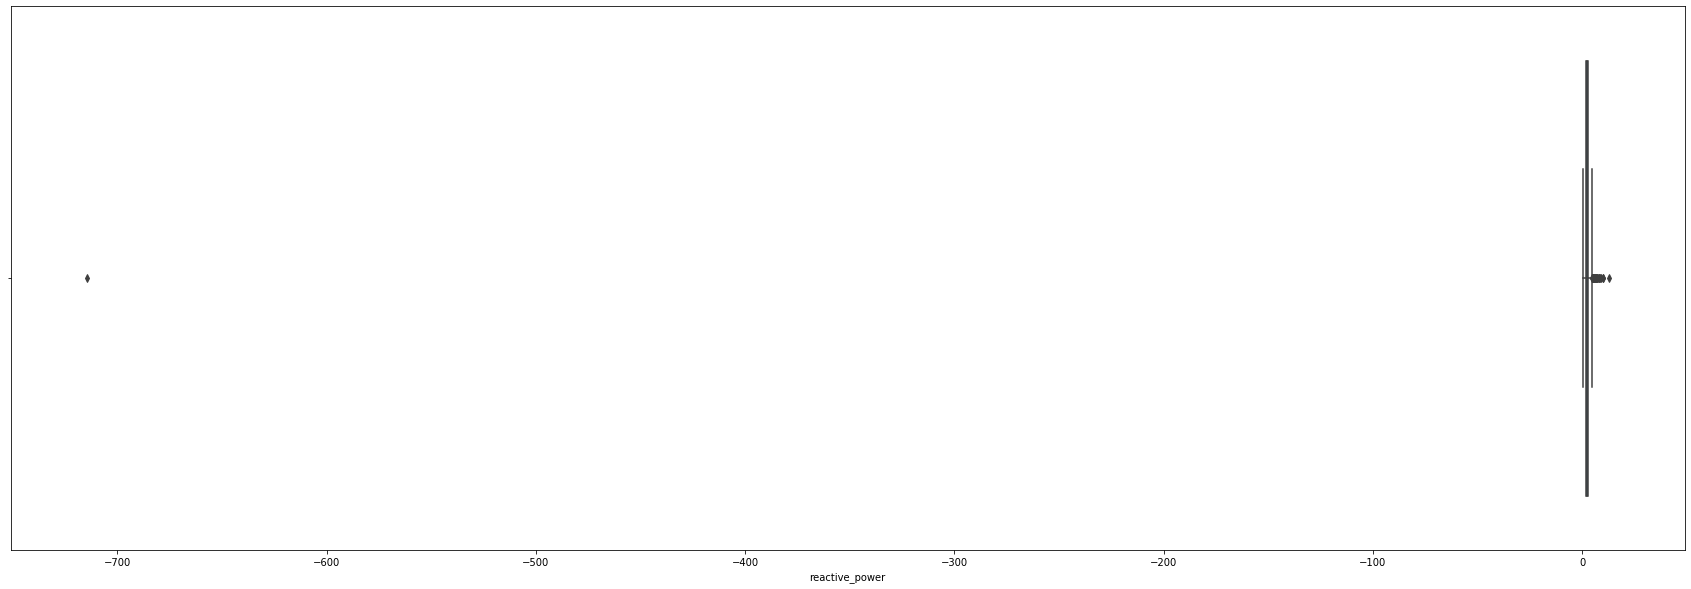

In [563]:
sns.boxplot(data_arc_key['reactive_power'])

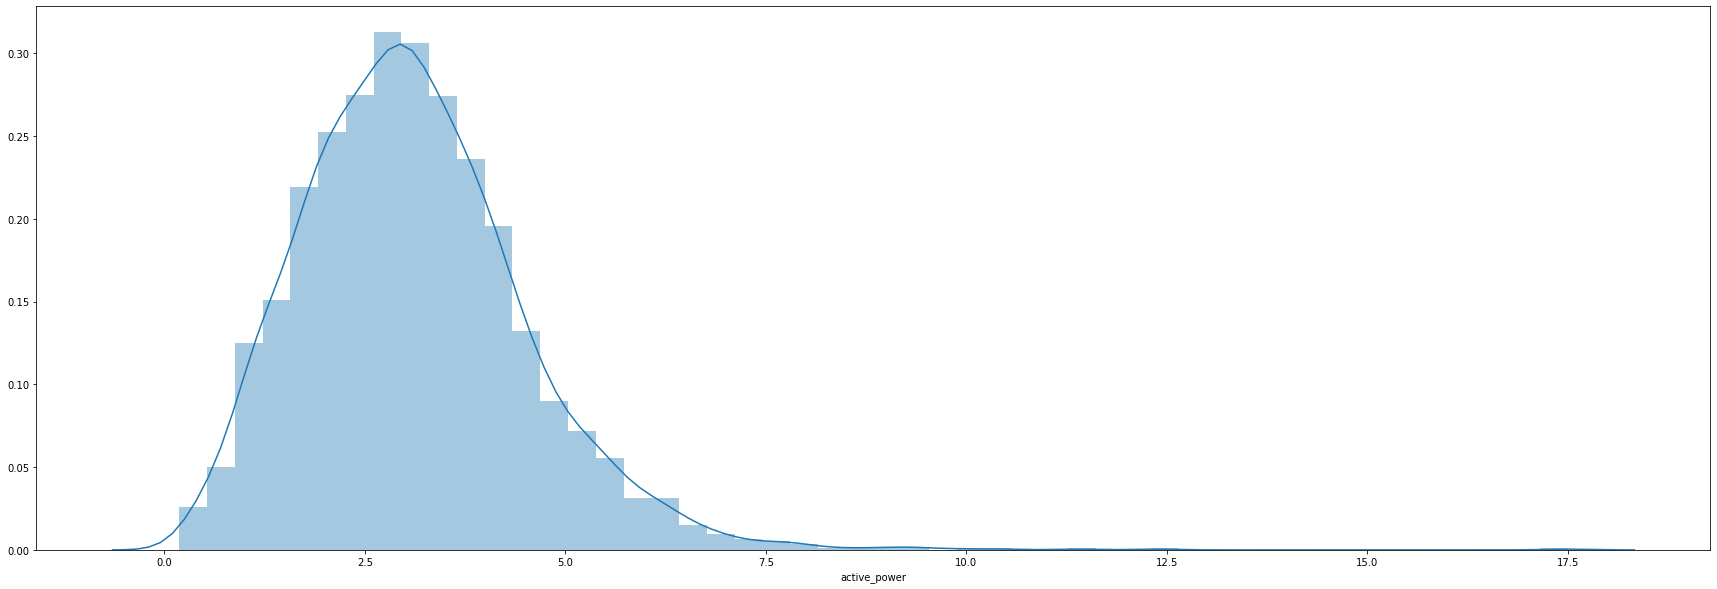

In [564]:
sns.distplot(data_arc_key['active_power'])

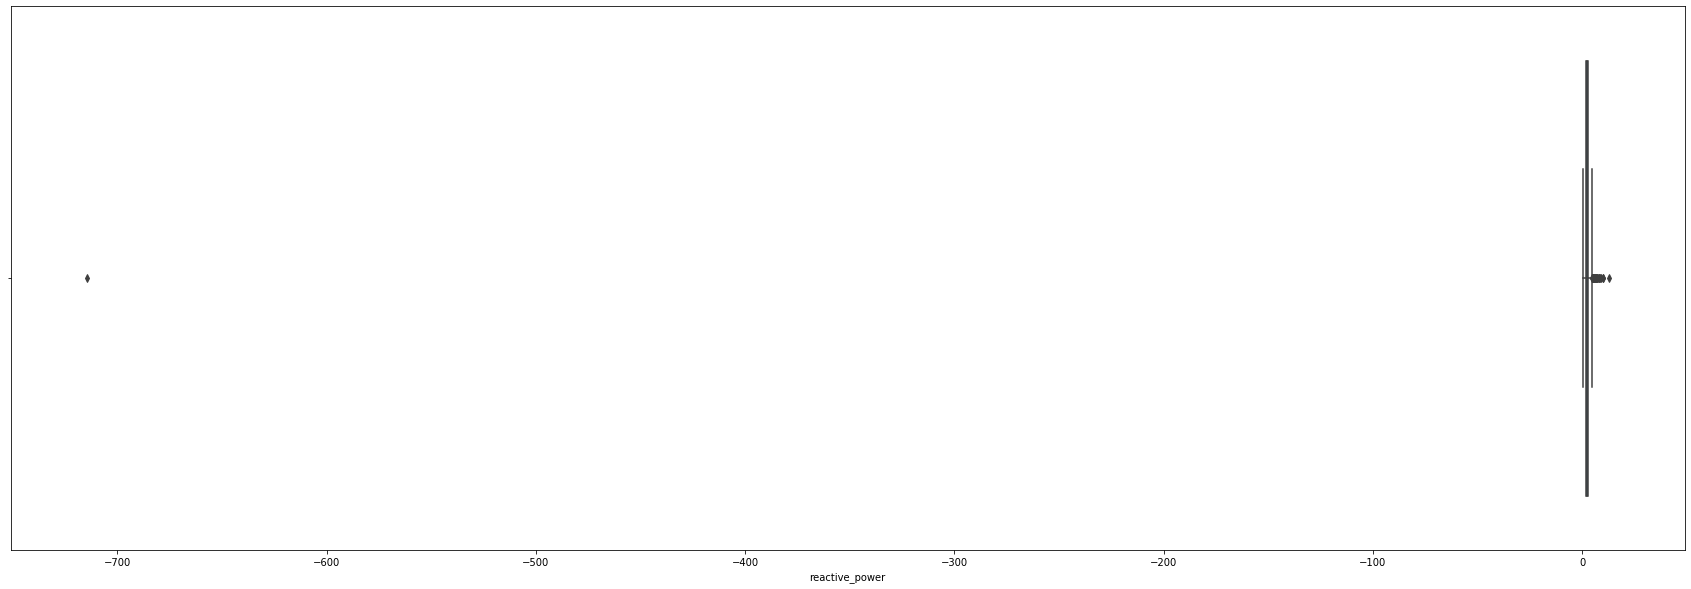

In [565]:
sns.boxplot(data_arc_key['reactive_power'])

In [566]:
data_arc_key = data_arc_key.query('reactive_power >= 0')
data_arc_key = data_arc_key.query('active_power >= 0')

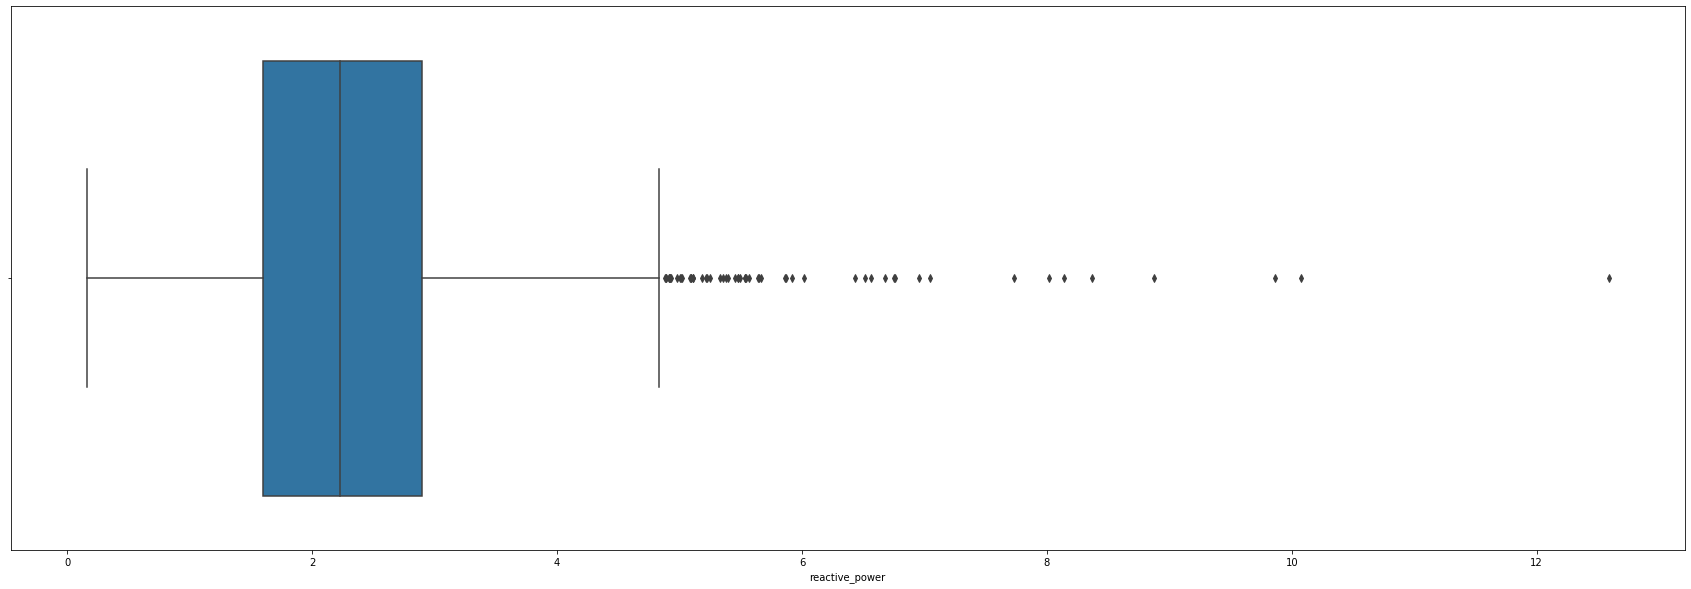

In [567]:
sns.boxplot(data_arc_key['reactive_power'])

In [568]:
data_arc_key = data_arc_key.query('reactive_power <=5')

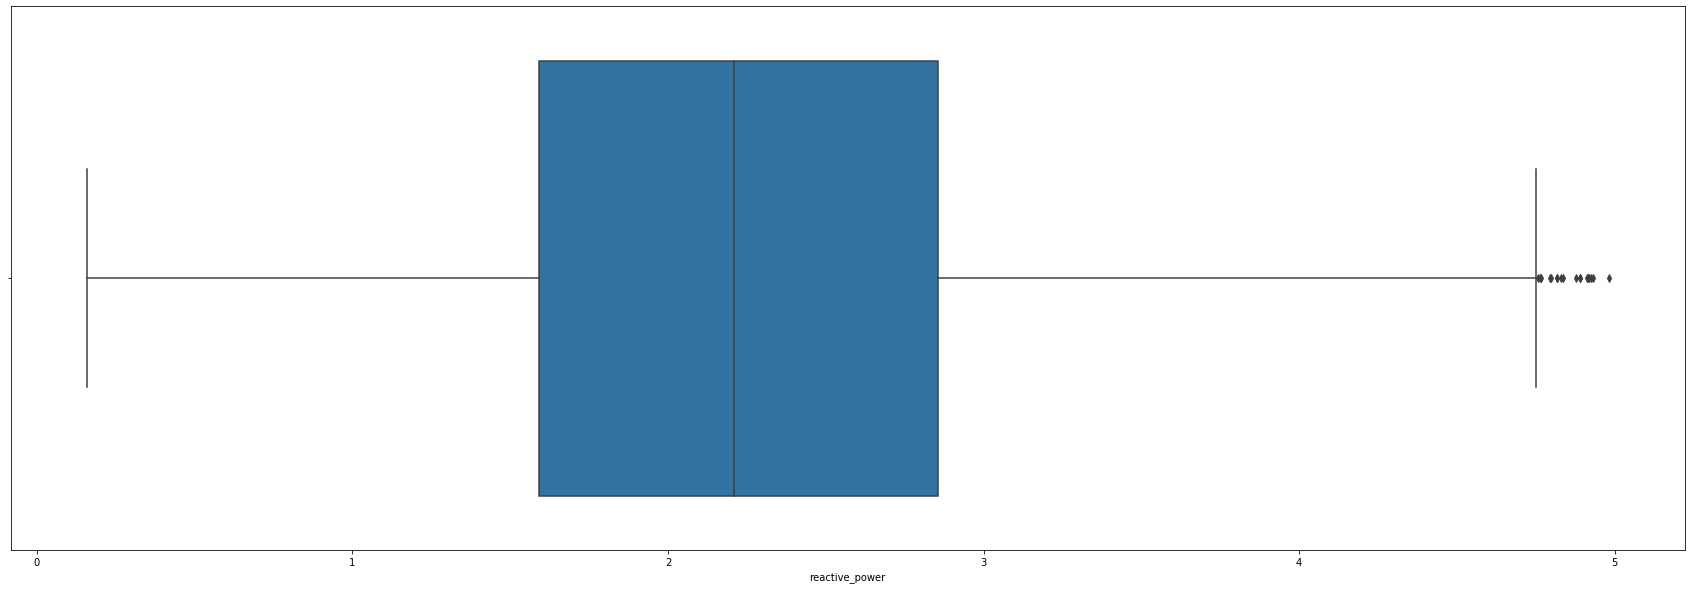

In [569]:
sns.boxplot(data_arc_key['reactive_power'])

In [570]:
data_arc_key = data_arc_key.query('reactive_power <=5')

In [571]:
del data_arc['key1']

In [572]:
data_arc.head(10)

,key,begin_heat_arc,finish_heat_arc,active_power,reactive_power,seconds_of_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,137
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,280


# data_bulk

In [573]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [574]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [575]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [576]:
data_bulk.columns = map(str.lower, data_bulk.columns)

In [577]:
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [578]:
data_bulk = data_bulk.fillna(0)

In [579]:
data_bulk.head(10)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
5,6,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
6,7,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0
7,8,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0
8,9,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0


In [580]:
data_bulk = data_bulk.astype(int)

In [581]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152


In [582]:
data_bulk_for_plot = data_bulk.drop(['key'], axis = 1)

In [583]:
data_bulk_for_plot = data_bulk_for_plot.query('bulk_12<1000')

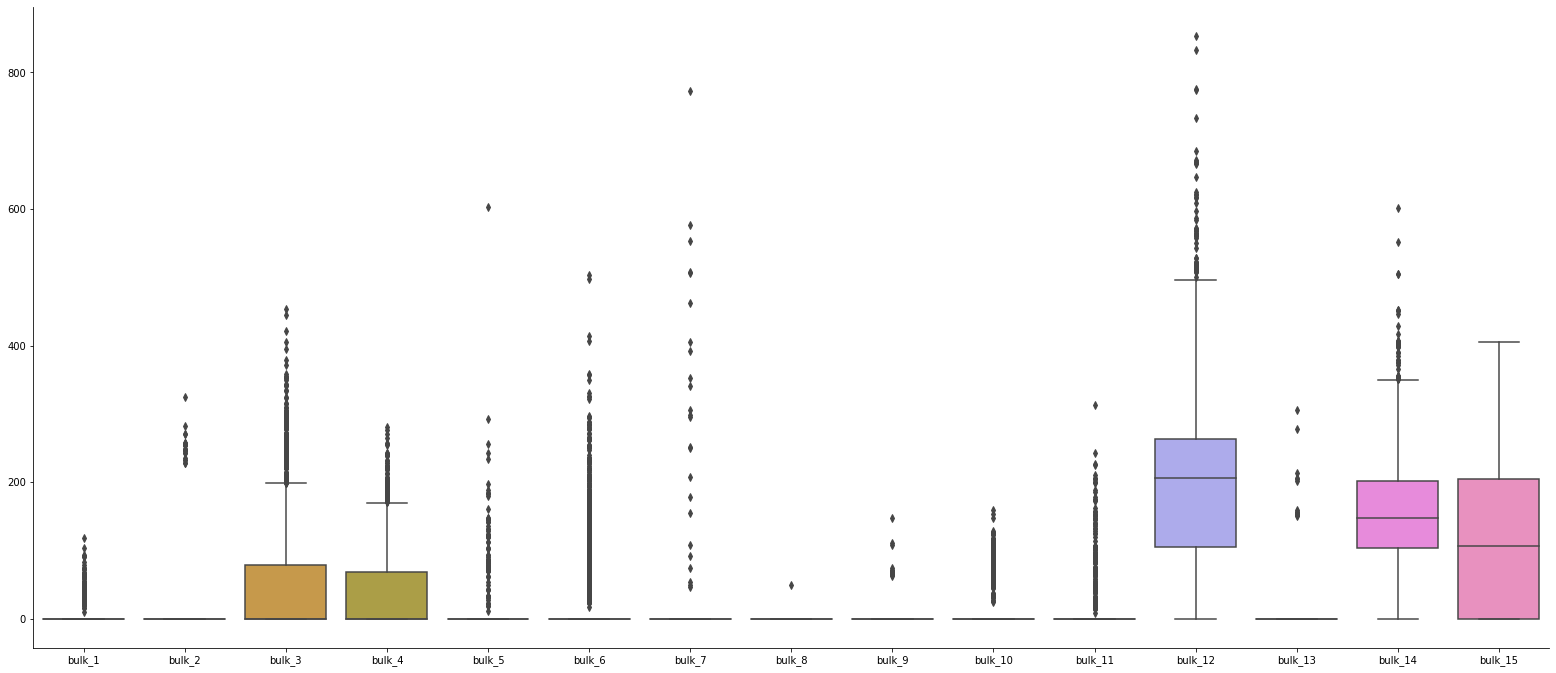

In [584]:

bulk_plot = sns.catplot(kind="box", data=data_bulk_for_plot);
bulk_plot.fig.set_size_inches(25, 10)  

In [585]:
#data_bulk_for_plot = data_bulk_for_plot.drop(['bulk_1', 'bulk_2','bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11','bulk_13'], axis = 1)

# data_bulk_time

In [586]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [587]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [588]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52



# data_gas

In [589]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [590]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [591]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [592]:
data_gas.columns = ['key', 'gas_1']

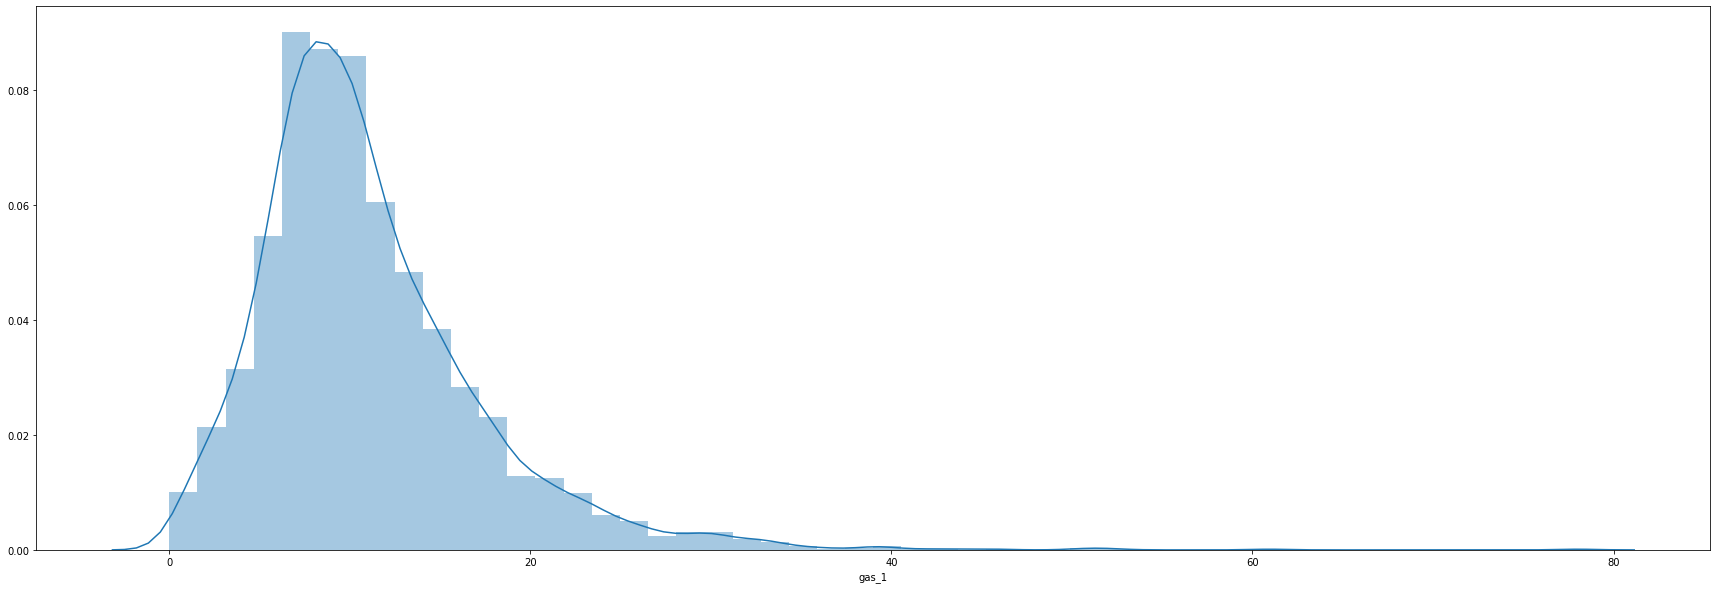

In [593]:
sns.distplot(data_gas['gas_1'])

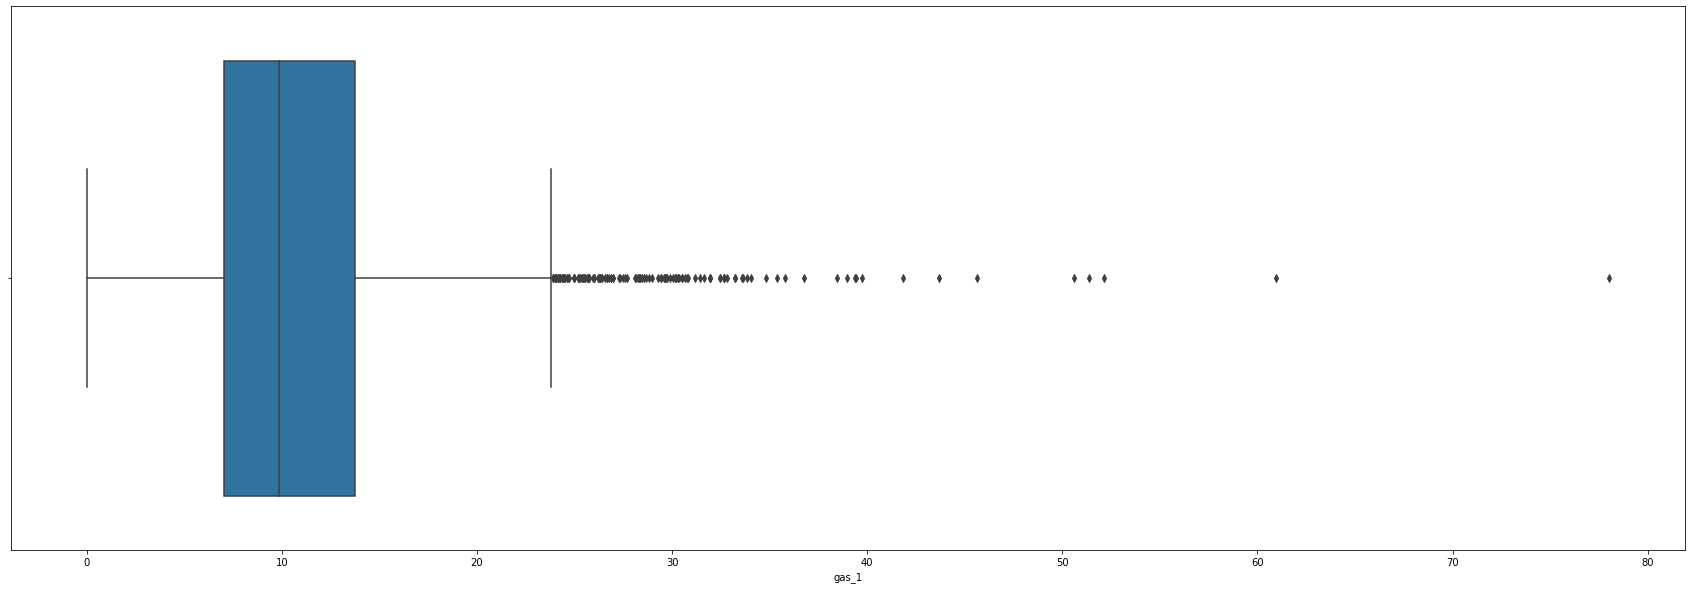

In [594]:
sns.boxplot(data_gas['gas_1'])

In [595]:
data_gas =data_gas.query('gas_1 <=25')

# data_temp

In [596]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [597]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [598]:
data_temp.head(30)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [599]:
data_temp.columns = ['key', 'measurement_time', 'temperature']

In [600]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

In [601]:
data_temp['temperature'].isnull().sum()

2901

In [602]:
data_temp = data_temp.groupby('key').filter(lambda x: x.shape[0] != 1)

In [603]:
first_temp = data_temp.loc[data_temp.groupby('key')['measurement_time'].agg(['idxmin']).stack()].drop_duplicates()
last_temp = data_temp.loc[data_temp.groupby('key')['measurement_time'].agg(['idxmax']).stack()].drop_duplicates()



In [604]:
last_temp = last_temp.reset_index(drop=True)
first_temp = first_temp.reset_index(drop=True)

In [605]:
first_temp.columns = ['key', 'first_measurement_time', 'first_temperature']

In [606]:
last_temp.columns = ['key', 'last_measurement_time', 'last_temperature']

In [607]:
first_temp.head(10)

,key,first_measurement_time,first_temperature
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
5,6,2019-05-03 13:49:24,1543.0
6,7,2019-05-03 14:19:43,1586.0
7,8,2019-05-03 15:07:18,1577.0
8,9,2019-05-03 15:37:03,1587.0
9,10,2019-05-03 16:14:29,1574.0


In [608]:
last_temp.head(10)

,key,last_measurement_time,last_temperature
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
5,6,2019-05-03 14:12:29,1596.0
6,7,2019-05-03 14:42:37,1599.0
7,8,2019-05-03 15:22:52,1598.0
8,9,2019-05-03 16:01:16,1592.0
9,10,2019-05-03 16:36:08,1593.0


In [609]:
last_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 3 columns):
key                      3214 non-null int64
last_measurement_time    3214 non-null datetime64[ns]
last_temperature         2475 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 75.5 KB


In [610]:
first_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 3 columns):
key                       3214 non-null int64
first_measurement_time    3214 non-null datetime64[ns]
first_temperature         3214 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 75.5 KB


In [611]:
last_temp

,key,last_measurement_time,last_temperature
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3209,3237,2019-08-31 23:05:43,NaN
3210,3238,2019-08-31 23:43:00,NaN
3211,3239,2019-09-01 02:24:15,NaN
3212,3240,2019-09-01 03:35:16,NaN


# data_wire

In [612]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [613]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [614]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [615]:
data_wire = data_wire.fillna(0)

In [616]:
data_wire.columns = ['key', 'Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5', 'Wire_6', 'Wire_7',
                     'Wire_8', 'Wire_9']

In [617]:
data_wire.columns = map(str.lower, data_wire.columns)

In [618]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [619]:
data_wire_for_plot = data_wire.drop(['key'], axis = 1)

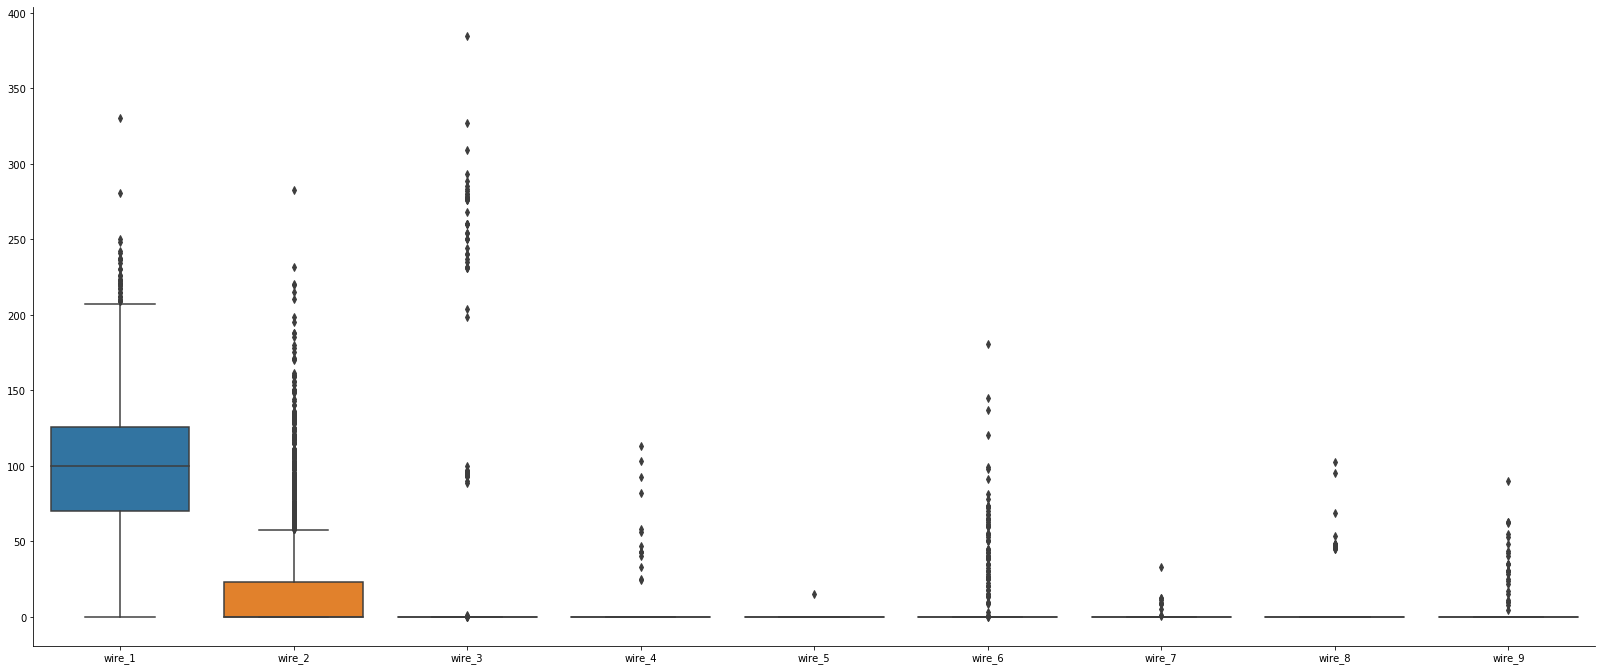

In [620]:
wire_plot = sns.catplot(kind="box", data=data_wire_for_plot);
wire_plot.fig.set_size_inches(25, 10) 

In [621]:
#data_wire = data_wire.drop([ 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis = 1)

# data_wire_time

In [622]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [623]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [624]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [625]:
merge1 = data_arc_key.merge(data_bulk, on='key', how='left')

In [626]:
merge2 = merge1.merge(data_wire, on='key', how='left')

In [627]:
merge3 = merge2.merge(data_gas, on='key', how='left')

In [628]:
merge4 = merge3.merge(first_temp, on='key', how='left') 

In [629]:
overall_data = merge4.merge(last_temp, on='key', how='left')

In [630]:
overall_data.head(10)

,key,number_of_heats,seconds_of_heating,active_power,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_measurement_time,first_temperature,last_measurement_time,last_temperature
0,1,5,1098,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,4,811,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.555561,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,5,655,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,4,741,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.841219,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,4,869,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.413692,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
5,6,4,952,3.955108,2.689175,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.273392,2019-05-03 13:49:24,1543.0,2019-05-03 14:12:29,1596.0
6,7,4,673,2.547375,1.561295,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.836267,2019-05-03 14:19:43,1586.0,2019-05-03 14:42:37,1599.0
7,8,4,913,3.762755,2.680698,0.0,0.0,0.0,99.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.171553,2019-05-03 15:07:18,1577.0,2019-05-03 15:22:52,1598.0
8,9,5,625,2.081951,1.478671,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.216623,2019-05-03 15:37:03,1587.0,2019-05-03 16:01:16,1592.0
9,10,6,825,2.923622,2.496116,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.529891,2019-05-03 16:14:29,1574.0,2019-05-03 16:36:08,1593.0


In [631]:
overall_data['last_temperature'].isnull().sum()

733

In [632]:
overall_data = overall_data.dropna(subset=['last_temperature']) 
overall_data['last_temperature'].isnull().sum()

0

In [633]:
overall_data = overall_data.fillna(0)

In [634]:
overall_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2432
Data columns (total 34 columns):
key                       2433 non-null int64
number_of_heats           2433 non-null int64
seconds_of_heating        2433 non-null int64
active_power              2433 non-null float64
reactive_power            2433 non-null float64
bulk_1                    2433 non-null float64
bulk_2                    2433 non-null float64
bulk_3                    2433 non-null float64
bulk_4                    2433 non-null float64
bulk_5                    2433 non-null float64
bulk_6                    2433 non-null float64
bulk_7                    2433 non-null float64
bulk_8                    2433 non-null float64
bulk_9                    2433 non-null float64
bulk_10                   2433 non-null float64
bulk_11                   2433 non-null float64
bulk_12                   2433 non-null float64
bulk_13                   2433 non-null float64
bulk_14                   2433 non-

In [635]:
overall_data.head(10)

,key,number_of_heats,seconds_of_heating,active_power,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_measurement_time,first_temperature,last_measurement_time,last_temperature
0,1,5,1098,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,4,811,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.555561,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,5,655,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,4,741,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.841219,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,4,869,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.413692,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
5,6,4,952,3.955108,2.689175,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.273392,2019-05-03 13:49:24,1543.0,2019-05-03 14:12:29,1596.0
6,7,4,673,2.547375,1.561295,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.836267,2019-05-03 14:19:43,1586.0,2019-05-03 14:42:37,1599.0
7,8,4,913,3.762755,2.680698,0.0,0.0,0.0,99.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.171553,2019-05-03 15:07:18,1577.0,2019-05-03 15:22:52,1598.0
8,9,5,625,2.081951,1.478671,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.216623,2019-05-03 15:37:03,1587.0,2019-05-03 16:01:16,1592.0
9,10,6,825,2.923622,2.496116,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.529891,2019-05-03 16:14:29,1574.0,2019-05-03 16:36:08,1593.0


In [636]:
convert_dict = {'bulk_1': int, 'bulk_2': int,'bulk_3': int, 'bulk_4': int, 'bulk_5': int, 'bulk_6': int, 'bulk_7': int, 
                'bulk_8': int, 'bulk_9': int, 'bulk_10': int, 'bulk_11': int,'bulk_12': int, 'bulk_13': int, 'bulk_14': int,
                'bulk_15': int, 'wire_1' : int, 'wire_2' : int, 'wire_3' : int, 'wire_4' : int, 'wire_5' : int, 'wire_6' : int,
               'wire_7' : int, 'wire_8' : int, 'wire_9' : int, 'first_temperature' : int, 'last_temperature': int} 

In [637]:
overall_data = overall_data.astype(convert_dict)

In [638]:
overall_data.head(10)

,key,number_of_heats,seconds_of_heating,active_power,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_measurement_time,first_temperature,last_measurement_time,last_temperature
0,1,5,1098,4.878147,3.183241,0,0,0,43,0,...,0,0,0,0,0,0.000000,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613
1,2,4,811,3.052598,1.998112,0,0,0,73,0,...,0,0,0,0,0,12.555561,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602
2,3,5,655,2.525882,1.599076,0,0,0,34,0,...,0,0,0,0,0,0.000000,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599
3,4,4,741,3.209250,2.060298,0,0,0,81,0,...,0,0,0,0,0,18.841219,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625
4,5,4,869,3.347173,2.252643,0,0,0,78,0,...,0,0,0,0,0,5.413692,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602
5,6,4,952,3.955108,2.689175,0,0,0,117,0,...,0,0,0,0,0,11.273392,2019-05-03 13:49:24,1543,2019-05-03 14:12:29,1596
6,7,4,673,2.547375,1.561295,0,0,0,117,0,...,0,0,0,0,0,9.836267,2019-05-03 14:19:43,1586,2019-05-03 14:42:37,1599
7,8,4,913,3.762755,2.680698,0,0,0,99,0,...,0,0,0,0,0,15.171553,2019-05-03 15:07:18,1577,2019-05-03 15:22:52,1598
8,9,5,625,2.081951,1.478671,0,0,0,117,0,...,0,0,0,0,0,8.216623,2019-05-03 15:37:03,1587,2019-05-03 16:01:16,1592
9,10,6,825,2.923622,2.496116,0,0,0,0,0,...,0,0,0,0,0,6.529891,2019-05-03 16:14:29,1574,2019-05-03 16:36:08,1593


In [639]:
del overall_data['first_measurement_time']

In [640]:
del overall_data['last_measurement_time']

In [641]:
overall_data.head(10)

,key,number_of_heats,seconds_of_heating,active_power,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_temperature,last_temperature
0,1,5,1098,4.878147,3.183241,0,0,0,43,0,...,0,0,0,0,0,0,0,0.000000,1571,1613
1,2,4,811,3.052598,1.998112,0,0,0,73,0,...,0,0,0,0,0,0,0,12.555561,1581,1602
2,3,5,655,2.525882,1.599076,0,0,0,34,0,...,0,0,0,0,0,0,0,0.000000,1596,1599
3,4,4,741,3.209250,2.060298,0,0,0,81,0,...,0,0,0,0,0,0,0,18.841219,1601,1625
4,5,4,869,3.347173,2.252643,0,0,0,78,0,...,0,0,0,0,0,0,0,5.413692,1576,1602
5,6,4,952,3.955108,2.689175,0,0,0,117,0,...,0,0,0,0,0,0,0,11.273392,1543,1596
6,7,4,673,2.547375,1.561295,0,0,0,117,0,...,0,0,0,0,0,0,0,9.836267,1586,1599
7,8,4,913,3.762755,2.680698,0,0,0,99,0,...,0,0,0,0,0,0,0,15.171553,1577,1598
8,9,5,625,2.081951,1.478671,0,0,0,117,0,...,0,0,0,0,0,0,0,8.216623,1587,1592
9,10,6,825,2.923622,2.496116,0,0,0,0,0,...,0,0,0,0,0,0,0,6.529891,1574,1593


## Анализ и и выводы по данным:

### Я открыл и проанализировал все таблицы, данные как мне кажется пришли ко мне в хорошем качестве, требующие минимально обработки. По построенным граффикам видно что данные имеют нормальное распределение. В них присутствуют выбросы, которые я будут "трогать" на этапе построения моделей, для того что бы понимать, как они влияют на качество.

### Из данных я сделал единую таблицу куда помимо существующих добавил столбцы с количеством циклов, временем нагрева в секундах, первой и последней температурой. Так же я заполнил пропуски сырья "0" пропуски температуры просто удалил, так как это наш целевой признак и заполнение его каким то способом негативно скажется на качестве модели.

### 2 таблицы из предствленных мне в моей работе не пригодтся - время внесения добавок, bulk  и wire

### Подготовка признаков 

#### целевой признак - температура последнего замера стали

In [642]:
target = overall_data['last_temperature']
features = overall_data.drop(['last_temperature', 'key'], axis = 1)

In [643]:
features.shape

(2433, 30)

In [660]:
features = features.drop(['bulk_8', 'bulk_9', 'bulk_10', 'bulk_13', 'bulk_7', 'wire_3', 'wire_4', 'wire_5','wire_7', 'wire_8', 'wire_9'], axis = 1)

In [661]:
features_train_0, features_valid, target_train_0, target_valid = train_test_split(
    features, target, test_size = 0.18, random_state = 12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_train_0, target_train_0, test_size = 0.22, random_state = 12345)

In [662]:
features_train.shape

(1556, 19)

In [663]:
features_valid.shape

(438, 19)

In [664]:
features_test.shape

(439, 19)

### Linear Regression

In [665]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
predictions_1 = model_1.predict(features_valid)
mean_absolute_error(target_valid, predictions_1)

6.93919859465447

In [666]:
print('LinearRegression_MAE', mean_absolute_error(target_valid, predictions_1))

LinearRegression_MAE 6.93919859465447


### Cat Boost Regressor

In [667]:
train_pool = Pool(features_train, target_train)
val_pool = Pool(features_valid, target_valid)
test_pool = Pool(features_test, target_test)

In [651]:
for i in range(3, 9):
    for j in range(100, 600, 50):
        cb_rmse = CatBoostRegressor(loss_function='RMSE',  depth= i, learning_rate=0.1, random_state= 12345, n_estimators=j, silent=True)
        cb_rmse.fit(train_pool, eval_set=test_pool)
        cb_rmse_pred = np.clip(cb_rmse.predict(val_pool), 0, None)   
        print('depth', i, 'n_estimators', j, eval_metric(target_valid.to_numpy(), cb_rmse_pred, 'MAE'))

depth 3 n_estimators 100 [6.353289246248574]
depth 3 n_estimators 150 [6.168375660288613]
depth 3 n_estimators 200 [6.077567524491961]
depth 3 n_estimators 250 [6.058099792486973]
depth 3 n_estimators 300 [6.061337964545535]
depth 3 n_estimators 350 [6.005443903557078]
depth 3 n_estimators 400 [6.003498815373405]
depth 3 n_estimators 450 [6.003498815373405]
depth 3 n_estimators 500 [6.003498815373405]
depth 3 n_estimators 550 [5.96356537537173]
depth 4 n_estimators 100 [6.164171708581951]
depth 4 n_estimators 150 [6.039642692895006]
depth 4 n_estimators 200 [5.990091919892308]
depth 4 n_estimators 250 [5.963578752372608]
depth 4 n_estimators 300 [5.892603603795857]
depth 4 n_estimators 350 [5.84596908516906]
depth 4 n_estimators 400 [5.838671822794996]
depth 4 n_estimators 450 [5.803225459090242]
depth 4 n_estimators 500 [5.7853959975506015]
depth 4 n_estimators 550 [5.7853959975506015]
depth 5 n_estimators 100 [6.068647018343851]
depth 5 n_estimators 150 [5.945354278669191]
depth 5 n_

depth 6 n_estimators 550 [5.653190935737426] - Лучший результат Cat Boost

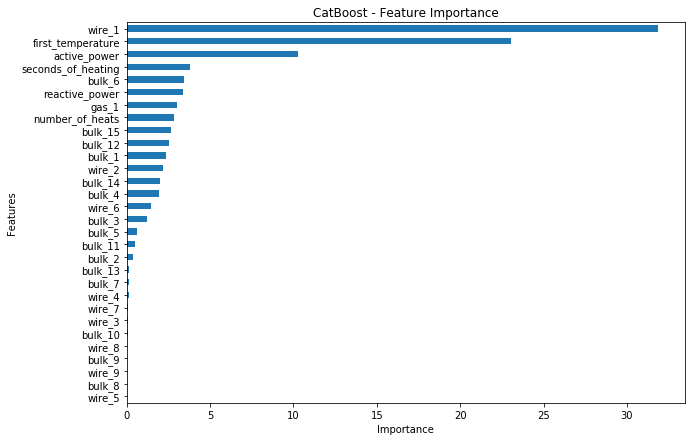

In [657]:
fea_imp = pd.DataFrame({'imp': cb_rmse.feature_importances_, 'col': features_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

### LGBM Regressor

In [653]:
for i in range(3, 9):
    for j in range(20, 40, 5):
        for l in range(50, 500, 50):
            model_2 = lgbm.sklearn.LGBMRegressor(max_depth = i, num_leaves = j, n_estimators = l)
            model_2.fit(features_train, target_train)
            predictions2 = model_2.predict(features_valid)
            mae = mean_absolute_error(target_valid, predictions2)
            print('depth', i, 'leaves', j, 'estimators', l, 'MAE=', mae)

depth 3 leaves 20 estimators 50 MAE= 6.3311821039151255
depth 3 leaves 20 estimators 100 MAE= 5.93920684370364
depth 3 leaves 20 estimators 150 MAE= 5.872050302902917
depth 3 leaves 20 estimators 200 MAE= 5.867184398822861
depth 3 leaves 20 estimators 250 MAE= 5.881355239200522
depth 3 leaves 20 estimators 300 MAE= 5.8845637226823
depth 3 leaves 20 estimators 350 MAE= 5.877798227662184
depth 3 leaves 20 estimators 400 MAE= 5.87295968278637
depth 3 leaves 20 estimators 450 MAE= 5.886024632521252
depth 3 leaves 25 estimators 50 MAE= 6.3311821039151255
depth 3 leaves 25 estimators 100 MAE= 5.93920684370364
depth 3 leaves 25 estimators 150 MAE= 5.872050302902917
depth 3 leaves 25 estimators 200 MAE= 5.867184398822861
depth 3 leaves 25 estimators 250 MAE= 5.881355239200522
depth 3 leaves 25 estimators 300 MAE= 5.8845637226823
depth 3 leaves 25 estimators 350 MAE= 5.877798227662184
depth 3 leaves 25 estimators 400 MAE= 5.87295968278637
depth 3 leaves 25 estimators 450 MAE= 5.886024632521252


Луший результат MAE= 5.61718571439229 при depth 3 leaves 20 estimators 350

### Проверка моделей на тестевой выборке

In [682]:
cb_rmse4 = CatBoostRegressor(loss_function='RMSE',  depth= 6, random_state= 12345, n_estimators=550, silent=True)
cb_rmse4.fit(train_pool, eval_set=test_pool)
cb_rmse_pred4 = np.clip(cb_rmse4.predict(test_pool), 0, None)
print('Catboost_MAE', eval_metric(target_test.to_numpy(), cb_rmse_pred4, 'MAE'))

Catboost_MAE [5.96753460264328]


In [669]:
model_3 = lgbm.sklearn.LGBMRegressor(max_depth = 3, num_leaves = 20, n_estimators = 350)
model_3.fit(features_train, target_train)
predictions3 = model_3.predict(features_test)


In [670]:
print('LGBM_MAE', mean_absolute_error(target_test, predictions3))

LGBM_MAE 6.1987646449639415


#### Так как результаты cat boos и lgbm regressor были близки я решил опробовать на тестевой выборке обе модели.
#### По итогу победи cat boost c с значением MAE на тестевых данных 5.96753460264328 она и будет моей моделью для внедрения в произзводство стали.





### Отчет о проделаной работе:



1. Я обработал данные более тщательно, поняв мою цель я кое что изменилв первично обработке, создал новые колонки - признаки. Изначально я планировал заполнить пропуски температуры каким то методом, но поняв что это мой целевой признак я просто эти пропуски удалил.
2. Разделил выборки
3. Построил 3 модели подбирая в циклах гиперпараметры, выбрал лучшую.
4. Протестировал результат на тестевых данных и получил значение метрики меньше 6, что от меня и требовалось


